In [ ]:
!pip install torch torchvision pillow scikit-image

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
class DIPModel(nn.Module):
    def __init__(self):
        super(DIPModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        return x

In [ ]:
def add_noise(image, noise_level):
    noise = torch.randn_like(image) * noise_level
    return image + noise

In [ ]:
def show_image(image, title=""):
    plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

In [23]:
def train_dip_with_denoising(dip_model, target_image, noise_levels, num_steps_per_level):
    optimizer = optim.Adam(dip_model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    for noise_level in noise_levels:
        noisy_image = add_noise(target_image, noise_level)

        show_image(noisy_image, f"Noise Level: {noise_level}")

        for step in range(num_steps_per_level):
            optimizer.zero_grad()
            output = dip_model(noisy_image)
            loss = criterion(output, noisy_image)
            loss.backward()
            optimizer.step()

        current_psnr = psnr(target_image.cpu().detach().numpy(), output.cpu().detach().numpy())
        print(f"Noise Level: {noise_level}, Step: {step}, PSNR: {current_psnr}")

In [ ]:
def load_image(filename):
    image = Image.open(filename).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0)

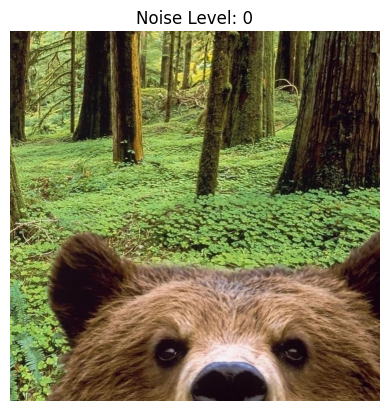

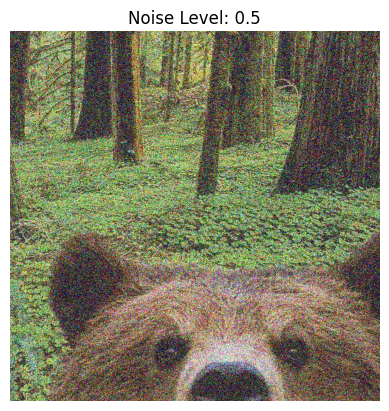

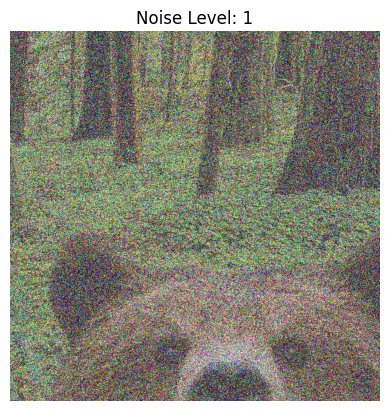

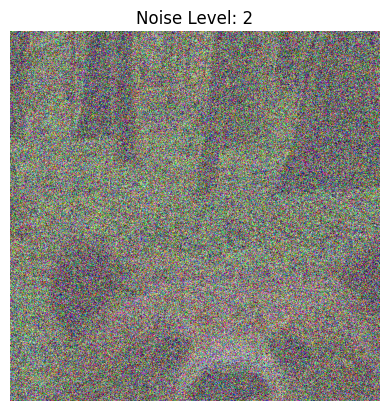

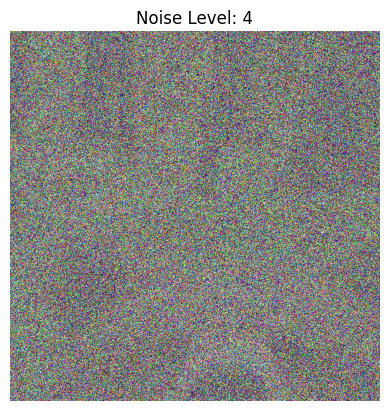

In [32]:
filename = "/content/image.jpg"
target_image = load_image(filename)
noise_levels = [0,0.5,1,2,4]
for noise_level in noise_levels:
        noisy_image = add_noise(target_image, noise_level)
        show_image(noisy_image, f"Noise Level: {noise_level}")

In [33]:
noise_levels = noise_levels[::-1]
noise_levels

[4, 2, 1, 0.5, 0]

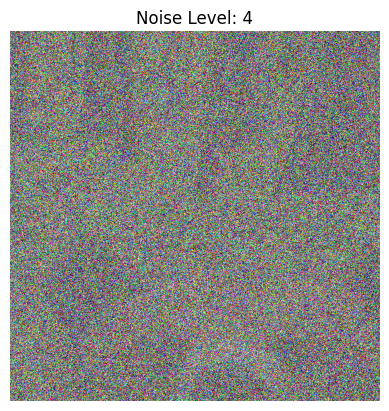

Noise Level: 4, Step: 99, PSNR: 5.401741434965375


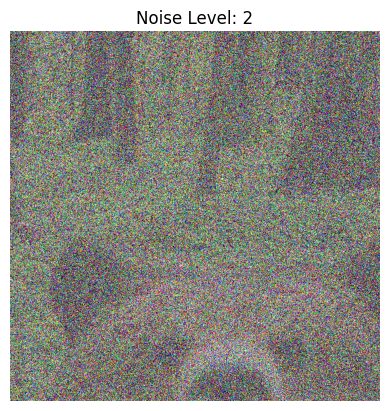

Noise Level: 2, Step: 99, PSNR: 5.81561562181479


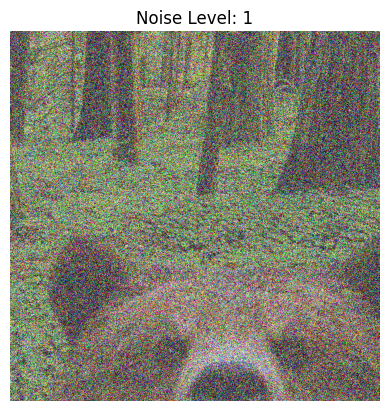

Noise Level: 1, Step: 99, PSNR: 6.738438482552316


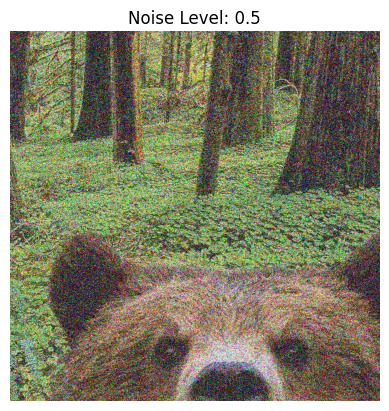

Noise Level: 0.5, Step: 99, PSNR: 9.023340118582787


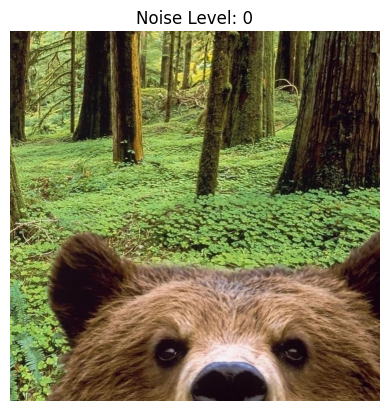

Noise Level: 0, Step: 99, PSNR: 35.80800259407138


In [34]:
# train DIP
num_steps_per_level = 100
dip_model = DIPModel()
train_dip_with_denoising(dip_model, target_image, noise_levels, num_steps_per_level)

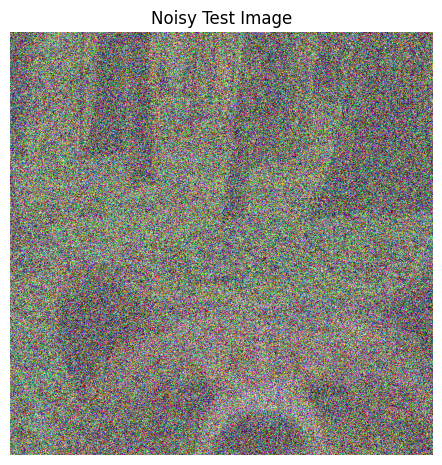

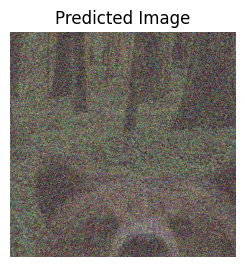

In [35]:
test_image = add_noise(target_image, 2)

with torch.no_grad():
    predicted_image = dip_model(test_image)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
show_image(test_image, "Noisy Test Image")

plt.subplot(1, 2, 2)
show_image(predicted_image, "Predicted Image")